In [1]:
import os
import argparse
import wandb
import re
import clip
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# add the parent directory to the path
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
                
from utils.dcbm import *



/home/pknab/miniconda3/envs/envi/lib/python3.10/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2024-11-14 21:24:20.713425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-11-14 21:24:20.713456: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# ----------------- Fix -----------------
embed_path = "../data/Embeddings/"
dataset = "imagenet"
class_labels_path = "../data/classes/imagenet_classes.txt"
segment_path = "../data/Segments/"
selected_image_concepts = "../data/Embeddings/subsets"
raw_path_dataset = # TODO
raw_path = #TODO: Define the path to the raw images

# ----------------- Hyperparameters -----------------

model_name = "CLIP-ViT-L14"  # "CLIP-ViT-L14", "CLIP-RN50", CLIP-ViT-B16

segmentation_technique = "SAM2"  # GDINO, SAM, SAM2, DETR, MaskRCNN
concept_name = None # Define for GDINE [awa, sun, sun-lowthresh, cub...]

device = "cpu"

clusters = 2048
cluster_method = "kmeans"  # "hierarchical", "kmeans"
centroid_method = "median"  # "mean", "median"

concept_per_class = 50  # How many images for each class 5,10,20,50, None

one_hot = False
epochs = 200
lambda_1 = 1e-4
lr = 1e-4
batch_size = 512

crop = False  # True without background

use_wandb = False
project = "YOUR_PROJECT_NAME"  # Define your own project name within wandb

In [4]:
cbm = CBM(
    embed_path, dataset, model_name, class_labels_path, device=device
)  # Initialize CBM

cbm.load_concepts(
    segment_path,
    segmentation_technique,
    concept_name,
    selected_image_concepts,
    concept_per_class,
    crop=crop,
)  # Load concepts with predefined segmentation technique and hyperparameters

if clusters is not None:  # if clustering is needed
    cbm.cluster_image_concepts(cluster_method, clusters)
else:
    cbm.clustered_concepts = cbm.image_segments

cbm.centroid_concepts(
    centroid_method
)  # Calculate centroids of the concepts with given method

cbm.preprocess_data(
    type_="standard", label_type=one_hot
)  # preprocess data for training
cbm_model = cbm.train(  # train the model
    num_epochs=epochs,
    lambda_1=lambda_1,
    lr=lr,
    batch_size=batch_size,
    device=device,
    project=project,
    to_print=False,
    early_stopping_patience=None,
    one_hot=one_hot,
    use_wandb=use_wandb,
)

PCA:  False
Number of image embeddings:  49188
Number of clusters:  2048
Clustering method:  kmeans


/home/pknab/miniconda3/envs/envi/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Processing Batches: 100%|██████████| 30/30 [00:00<00:00, 663.03it/s]


(1153049, 2048) (50000, 2048) (128118, 2048) (1153049, 1000) (50000, 1000) (128118, 1000)


In [7]:
cbm_model = cbm_model
model = CBM_Model(
    cbm_model, cbm.clustered_concepts, cbm.preprocess_module, cbm.scaler, device=device
)
print("Predictions: ")
print(model.predict_processed(cbm.X_test[:200]))
print("True Classes: ")
print(np.argmax(cbm.y_test[:200], axis=1))

Predictions: 
[334 207 897 905 459 110   4 241 398 645 626 965 310 437 802 592 239 487
  12 365 194 644 514 933 298 705 920 775 577 133 767 184 974 710 814 311
 387 254 586 999 715 364 884  98 854 750  28 720 573 542 588 508 347 648
 620 360 344 852 653 466 511 951 865 584 980 435 191 176 895 377 655  52
 577 341 764 181 754 847 936 445 406 812  94 474 503 706 568 440 688 443
 958 195 445 603 977 435 443 679 642 247 565 235 500 478 922 875 332 597
 244 310  56 739 153 709  87 476 943 605 213 351 721  33 722 392 273 433
 343 278 543 913 420 121 443 994 713 507 943 493 335 322 846 765 100 750
 445 985 870 945 343 719 244 569 651 760 978  27 471 768 883 695 736 270
 403 570 124 517 363 544 383  21 937 626  30 210 267 762 292   4 805 846
  77 898  99 354 405  77 492 929 617 592  42 153 488 688  17 712  58 552
 508 653]
True Classes: 
[334 208 897 789 743 329   3 241 543 822 606 965 310 437 802 732 226 732
  12 365 190 626 514 933 298 705 800 735 577 133 767 184 974 710 975 311
 387 245 586

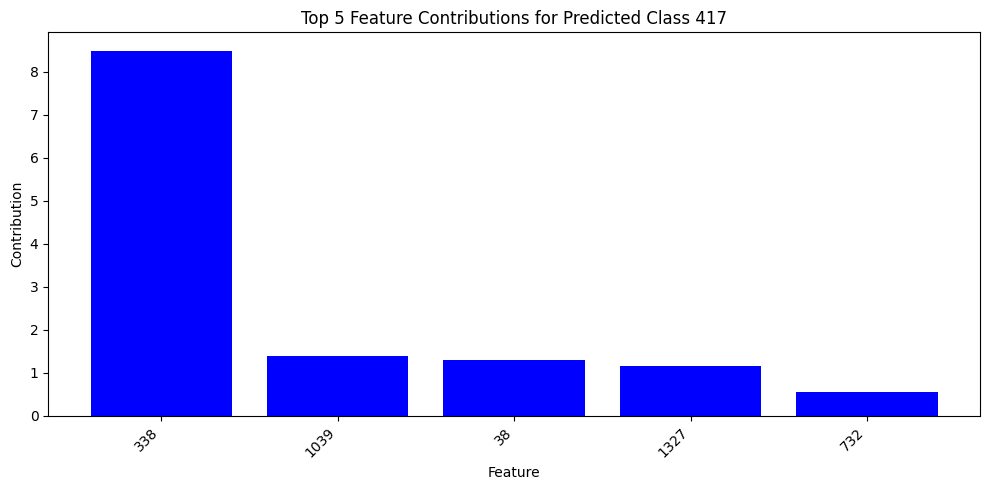

True Class: balloon
Predicted Class: balloon


array([8.4953985 , 1.3827708 , 1.3104347 , 1.1534399 , 0.56305623],
      dtype=float32)

In [8]:
id_image = 444

concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)


In [10]:
model, preprocess = clip.load("ViT-L/14", device=device, jit=False)

with open("..data/classes/20k.txt", "r") as f:
    g20k = f.readlines()
names = [i.strip() for i in g20k]
tokenized_text = clip.tokenize(names).to(device)

with torch.no_grad():
    text_features = model.encode_text(tokenized_text)
        

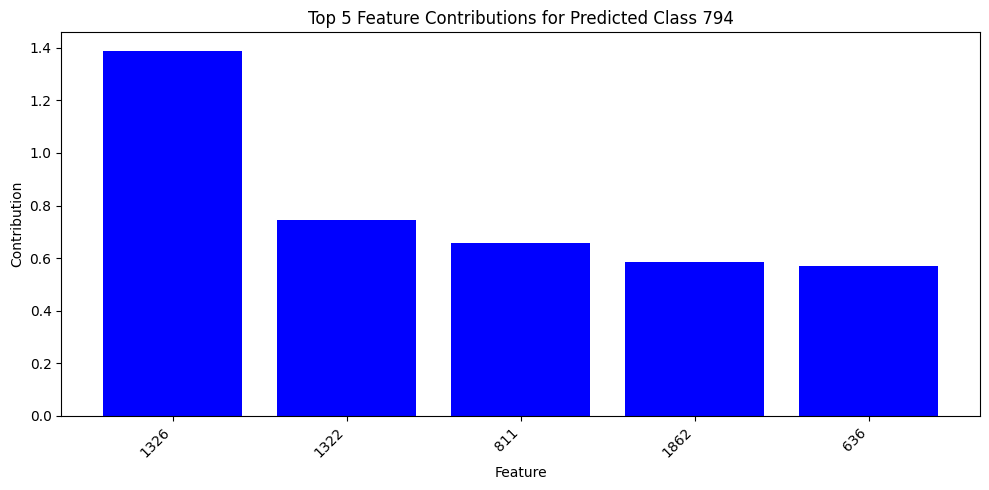

True Class: plastic bag
Predicted Class: shower curtain
id_image 39691
n03958227
['../Segments/ImageNet_SAM2/crops/n04532106/n04532106_11461_OUT_CROP_0_X_.jpg', '../Segments/ImageNet_SAM2/crops/n07697313/n07697313_2487_OUT_CROP_0_X_.jpg', '../Segments/ImageNet_SAM2/crops/n03938244/n03938244_20037_OUT_CROP_0_X_.jpg', '../Segments/ImageNet_SAM2/crops/n03388549/n03388549_2269_OUT_CROP_5_X_.jpg', '../Segments/ImageNet_SAM2/crops/n04033995/n04033995_10963_OUT_CROP_82_X_.jpg']
../Datasets/ImageNet/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00016676.JPEG


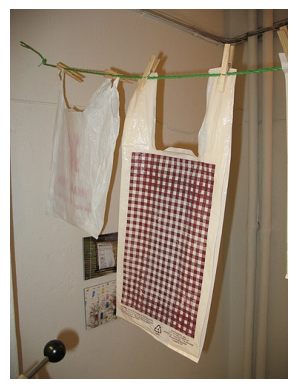

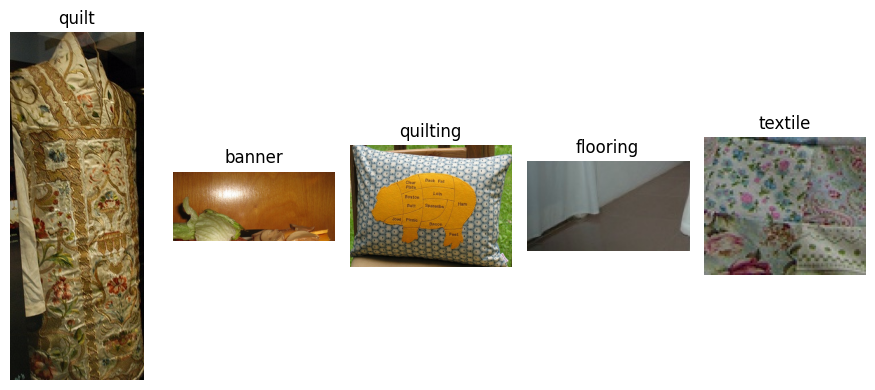

In [66]:
def display_images_with_main(image_paths, main_image_path, concept_names, num_secondary=5):
    """
    Display a main image prominently and a series of smaller images in a row layout.

    Parameters:
    - image_paths (list): List of file paths for the secondary images.
    - main_image_path (str): File path of the main image to be displayed larger.
    - num_secondary (int): Number of secondary images to display. Default is 5.
    """
    # Remove duplicates from image paths
    image_paths = image_paths[:num_secondary]
    print(main_image_path)
    # print(image_paths)
    # Display the main image
    main_img = Image.open(main_image_path)
    plt.imshow(main_img)
    plt.axis("off")

    # Set up the grid: main image in a larger size, followed by smaller images
    fig, axes = plt.subplots(1, num_secondary, figsize=(9, 4))

    # Display each of the secondary images
    for i, image_path in enumerate(image_paths):
        img = cv2.imread(image_path)

        # Image data of dtype object cannot be converted to float
        try:
            axes[i].imshow(img)
        except:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(concept_names[i])

    plt.tight_layout()
    plt.show()


def display_concepts(id_image, cbm, raw_path, raw_path_dataset):

    def extract_until_number(strings):
        return [process_string(s) for s in strings]

    def process_string(s):
        return s.split("_")[0]

    concept_ids, concept_weights = cbm.plot_instance_feature_importance(id_image)
    clustered_concepts = cbm.clustered_concepts_all
    # Get the main image path
    print("id_image", id_image)
    image_name = list(cbm.data_test_raw.keys())[id_image]

    folder_name = cbm.data_test_labels_raw[id_image]
    # image_name = image_name.split(folder_name + "_")[1]
    image_path_org = os.path.join(raw_path_dataset, image_name)
    image_path_org = image_path_org + ".JPEG"
    # Find paths to median images based on feature importance (as in your example)
    image_median_paths = []
    concept_names = []
    for idx in concept_ids[:5]:
        #print(idx)
        idx = int(idx)
        data = clustered_concepts[idx]
        median_values = np.median(data, axis=0)
        distances = np.sum(np.abs(data - median_values), axis=1)
        median_index = np.argmin(distances)
        clustered_images = cbm.image_segments_names
        median_index = np.argsort(distances)
        # median_index is numeric which retrieves the embedding and path

        # Select up to n images closest to median
        n = 20
        median_entries = [clustered_images[idx][i] for i in median_index[:n]]
        
        concept_emb = data[median_index[0]]
        concept_emb = torch.tensor(concept_emb).to("cpu")
        sim = torch.nn.functional.cosine_similarity(concept_emb, text_features).cpu().float()

        top_index = sim.argsort(descending=True)

        # Process and add paths for the secondary images
        def construct_path(strings):
            correct_strings = []
            for substring in strings:
                folder_name = substring.split("_")[0]
                local_folder_names = os.listdir(raw_path + "/" + folder_name)
                #print(raw_path + "/" + folder_name, substring)
                for i in range(len(local_folder_names)):
                    if substring.lower() in local_folder_names[i].lower():
                        substring = local_folder_names[i]
                        break

                substring = os.path.join(raw_path, folder_name, substring)
                correct_strings.append(substring)
            return correct_strings

        image_median_paths.append(construct_path(median_entries)[0])
        concept_names.append(names[top_index[0]])
    # Call the function to display images
    display_images_with_main(image_median_paths, image_path_org, concept_names)

id_image = random.randint(0, len(cbm.data_test_raw))

display_concepts(id_image, cbm, raw_path, raw_path_dataset)